In [3]:
%load_ext autoreload
%autoreload 2

## Demo for interacting with the curriculum manager

In [1]:
from aind_auto_train.curriculum_manager import CurriculumManager
from aind_auto_train.schema.task import Task, TrainingStage, DynamicForagingMetrics
from aind_auto_train import setup_logging
setup_logging()

Instantiate the curriculum manager by connecting to the S3 bucket where the curriculum is stored.

In [3]:
curriculum_manager = CurriculumManager(
    saved_curriculums_on_s3=dict(
        bucket='aind-behavior-data',
        root='foraging_auto_training/saved_curriculums/'
    ),
    saved_curriculums_local='/root/capsule/scratch/tmp/'
)

Get a list of all available curriculums.

In [4]:
curriculum_manager.df_curriculums()

,curriculum_task,curriculum_version,curriculum_schema_version,curriculum_description
0,Coupled Baiting,0.1,0.2,Base curriculum for the coupled-baiting task
1,Coupled Baiting,0.2,0.2,More stringent criteria before GRADUATED than 0.1
2,Dummy task,0.1,0.2,


Retrieve a curriculum.

In [12]:
_curr = curriculum_manager.get_curriculum(
    curriculum_task='Coupled Baiting',
    curriculum_version='0.1',
    curriculum_schema_version='0.2',
)
_curr

2023-12-20 15:10:40 | INFO | aind_auto_train.curriculum_manager | Loaded a DynamicForagingCurriculum model from 'Coupled Baiting_curriculum_v0.1_schema_v0.2.json'.


{'curriculum': DynamicForagingCurriculum(curriculum_schema_version='0.2', curriculum_task='Coupled Baiting', curriculum_version='0.1', curriculum_description='Base curriculum for the coupled-baiting task', parameters={<TrainingStage.STAGE_1: 'Stage 1'>: DynamicForagingParas(task='Coupled Baiting', task_schema_version='1.0', curriculum_version='0.1', training_stage=<TrainingStage.STAGE_1: 'Stage 1'>, description="Phase B in Han's slides (block = [10, 20, 5], p_sum = 0.8, p_ratio = [1:0])", BaseRewardSum=0.8, RewardFamily=3, RewardParisN=1, UncoupledReward='', BlockMin=10, BlockMax=20, BlockBeta=5, BlockMinReward=0, DelayMin=0.5, DelayMax=0.5, DelayBeta=0.0, AutoReward=True, AutoWaterType='Natural', Multiplier=0.5, Unrewarded=5, Ignored=5, ITIMin=1.0, ITIMax=7.0, ITIBeta=3.0, ITIIncrease=0.0, ResponseTime=5.0, RewardConsumeTime=3.0, StopIgnores=20000, AdvancedBlockAuto='now', SwitchThr=0.5, PointsInARow=5, MaxTrial=1000, MaxTime=90, RightValue=0.05, LeftValue=0.05, RightValue_volume=5.0,

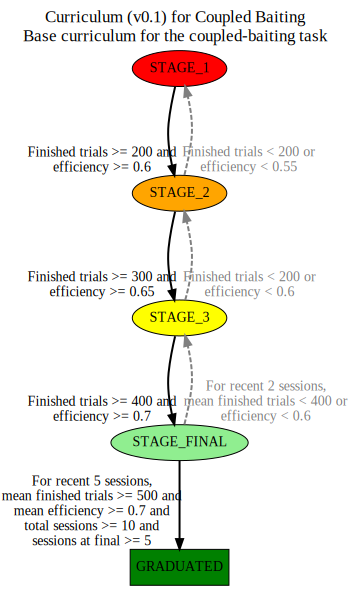

In [13]:
curriculum = _curr['curriculum']
curriculum.diagram_rules(render_file_format='')

If `dot` is not installed, we can load the pre-generated .svg file

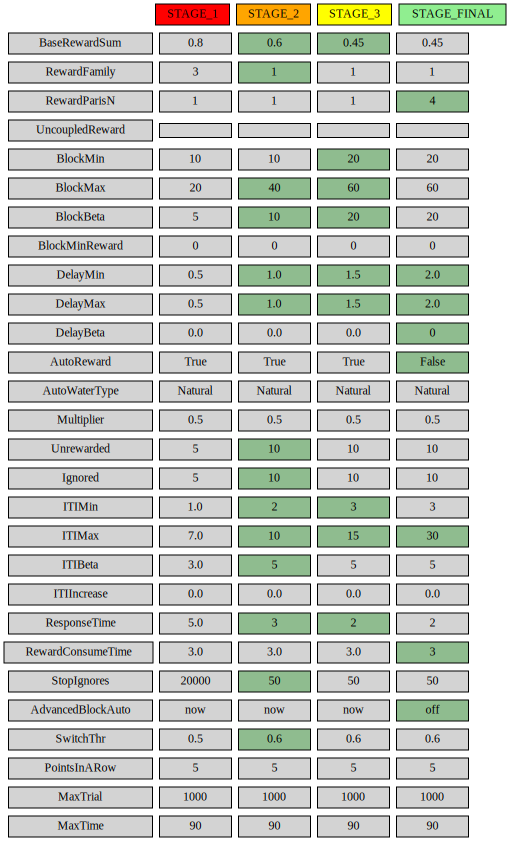

In [16]:
from IPython.display import SVG, display

# Display the SVG file
display(SVG(filename=_curr['diagram_paras_name']))

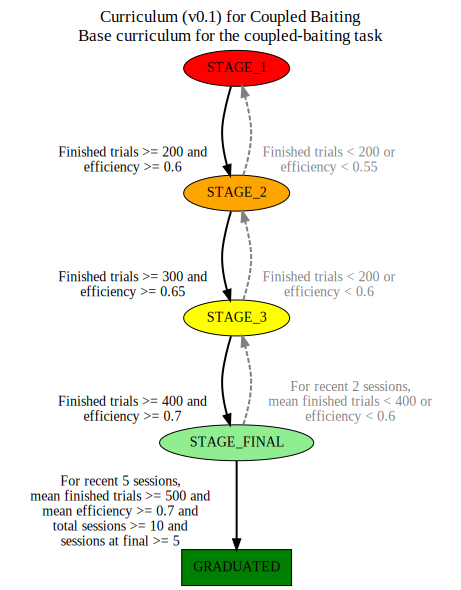

In [17]:
display(SVG(filename=_curr['diagram_rules_name']))

In [22]:
from aind_auto_train.schema.task import Task, TrainingStage

In [18]:
metrics_model = _curr['metrics']
metrics_model.model_fields

{'session_total': FieldInfo(annotation=int, required=True),
 'session_at_current_stage': FieldInfo(annotation=int, required=True),
 'foraging_efficiency': FieldInfo(annotation=List[float], required=True),
 'finished_trials': FieldInfo(annotation=List[int], required=True)}

Retrieve a condition

In [25]:
print(curriculum.curriculum[TrainingStage.STAGE_1].transition_rules[0].condition)

lambda metrics:
                        metrics.finished_trials[-1] >= 200
                        and
                        metrics.foraging_efficiency[-1] >= 0.6
                        


Try evaluating a session.

In [26]:
curriculum.evaluate_transitions(
    current_stage=TrainingStage.STAGE_1,
    metrics=metrics_model(
        session_total=1,
        session_at_current_stage=1,
        foraging_efficiency=[0.6],
        finished_trials=[199]
    )
)

(<Decision.STAY: 'stay'>, <TrainingStage.STAGE_1: 'Stage 1'>)

In [27]:
curriculum.evaluate_transitions(
    current_stage=TrainingStage.STAGE_1,
    metrics=metrics_model(
        session_total=1,
        session_at_current_stage=1,
        foraging_efficiency=[0.6],
        finished_trials=[200]
    )
)

(<Decision.PROGRESS: 'progress'>, <TrainingStage.STAGE_2: 'Stage 2'>)